In [283]:
import random

import numpy as np
import tensorflow as tf
from sklearn import metrics
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt

import pandas as pd

ACTIVATION = 'relu'
SEED_VALUE = 42
NUM_CLASSES = 10

random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [284]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [285]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [286]:
def build_model():
    return models.Sequential([
        layers.Flatten(input_shape=(28, 28)), 
        layers.Dense(128, activation=ACTIVATION), 
        layers.Dense(64, activation=ACTIVATION),   
        layers.Dense(NUM_CLASSES)                      
    ])

In [287]:
def plot_history(history):
    reports = []

    for index, row in history.iterrows():
        result = metrics.classification_report(np.argmax(row['Predictions'], axis=-1), test_labels, output_dict=True)
        reports.append(result)

    fig, ax = plt.subplots(3, 10, figsize=(15, 6))
    fig.tight_layout(pad=1.0)

    for label in range(10):
        history = pd.DataFrame(list(map(lambda r: r[f'{label}'], reports)))

        ax[0, label].plot(history['precision'], label='precision')
        ax[0, label].set_xlabel('Epoch')
        ax[0, label].set_ylabel('Precision')
        ax[0, label].set_ylim([0, 1])

        ax[1, label].plot(history['recall'], label='recall')
        ax[1, label].set_xlabel('Epoch')
        ax[1, label].set_ylabel('Recall')
        ax[1, label].set_ylim([0, 1])

        ax[2, label].plot(history['f1-score'], label='f1_score')
        ax[2, label].set_xlabel('Epoch')
        ax[2, label].set_ylabel('F1Score')
        ax[2, label].set_ylim([0, 1])

    plt.show()

In [288]:
class TrainingResults(tf.keras.callbacks.Callback): 
   def __init__(self, val_data, optimizer):
      super().__init__()
      self.validation_data = val_data
      self.optimizer = optimizer
   
   """the rest is Kenan's code"""         
   def on_epoch_end(self, epoch, logs={}):
      y_pred = self.model.predict(test_images)
      training_results_by_epochs[self.optimizer] = pd.concat([training_results_by_epochs[self.optimizer], pd.DataFrame({'Predictions': [y_pred]})], ignore_index=True)

In [289]:
optimizers_tuned = {
    'SGD': tf.keras.optimizers.SGD(learning_rate=0.001), 
    'Adam': tf.keras.optimizers.Adam(),
    'RMSprop': tf.keras.optimizers.RMSprop(),
    'Adagrad': tf.keras.optimizers.Adagrad(),
}

training_results_by_epochs = {
    'SGD': pd.DataFrame(), 
    'Adam': pd.DataFrame(),
    'RMSprop': pd.DataFrame(),
    'Adagrad': pd.DataFrame(),
}

def test_model(model, optimizer):
    model.compile(optimizer=optimizers_tuned[optimizer],
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    print(f'\nTesting: {optimizer}')
    history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels), verbose=False, callbacks=[
        TrainingResults((test_images, test_labels), optimizer)
    ])
    
    reached_90 = next((i + 1 for i, e in enumerate(history.history["val_accuracy"]) if e >= 0.9), np.inf) 

    if reached_90 == np.inf:
        print('\nNever reached 90% accuracy')
    else:
        print(f'\nReached 90% accuracy in {reached_90} epochs')

    results = model.predict(test_images)
    print(metrics.classification_report(np.argmax(results, axis=-1), test_labels))

    plot_history(training_results_by_epochs[optimizer])

    return (history, model)


Testing: SGD
313/313 [==============================] - 0s 1ms/step

Reached 90% accuracy in 2 epochs
313/313 [==============================] - 0s 990us/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1007
           1       0.99      0.97      0.98      1148
           2       0.94      0.94      0.94      1031
           3       0.95      0.92      0.94      1042
           4       0.96      0.94      0.95       994
           5       0.94      0.95      0.94       880
           6       0.96      0.95      0.96       970
           7       0.94      0.96      0.95      1008
           8       0.91      0.95      0.93       930
           9       0.92      0.94      0.93       990

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



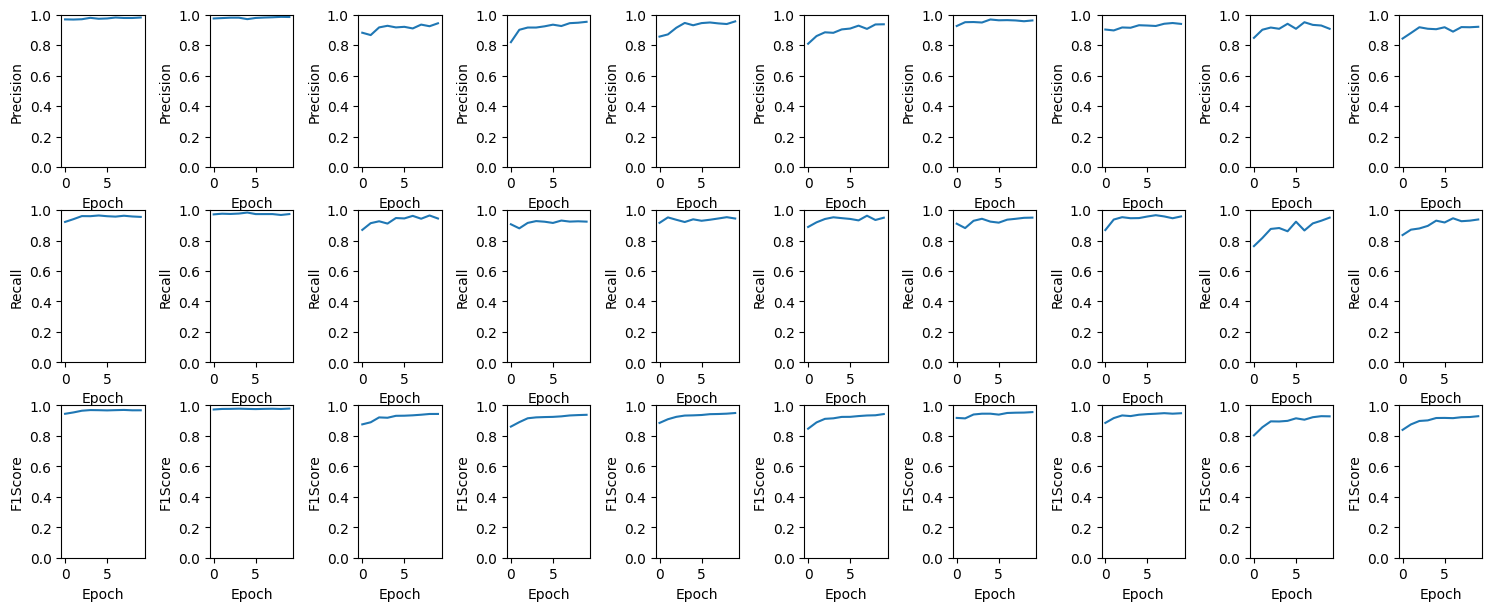


Testing: Adam
313/313 [==============================] - 0s 1ms/step

Reached 90% accuracy in 1 epochs
313/313 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       978
           1       0.99      0.99      0.99      1132
           2       0.95      0.98      0.97       996
           3       0.99      0.91      0.95      1093
           4       0.97      0.98      0.97       972
           5       0.96      0.94      0.95       908
           6       0.98      0.98      0.98       965
           7       0.96      0.98      0.97      1004
           8       0.92      0.95      0.93       949
           9       0.96      0.97      0.96      1003

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



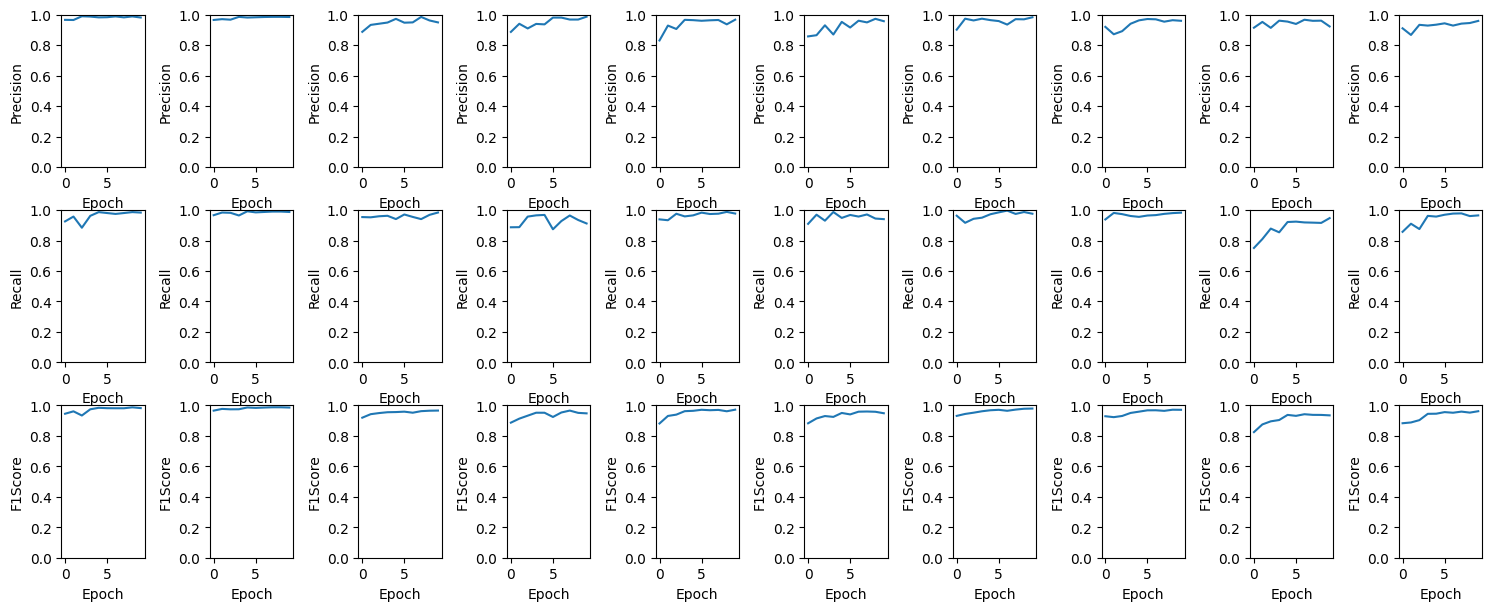


Testing: RMSprop
313/313 [==============================] - 0s 1ms/step

Reached 90% accuracy in 2 epochs
313/313 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       979
           1       0.96      0.98      0.97      1116
           2       0.93      0.96      0.95       991
           3       0.78      0.99      0.87       791
           4       0.90      0.99      0.94       890
           5       0.93      0.96      0.94       868
           6       0.96      0.98      0.97       940
           7       0.95      0.98      0.96       990
           8       0.98      0.57      0.72      1693
           9       0.72      0.98      0.83       742

    accuracy                           0.91     10000
   macro avg       0.91      0.94      0.91     10000
weighted avg       0.92      0.91      0.90     10000



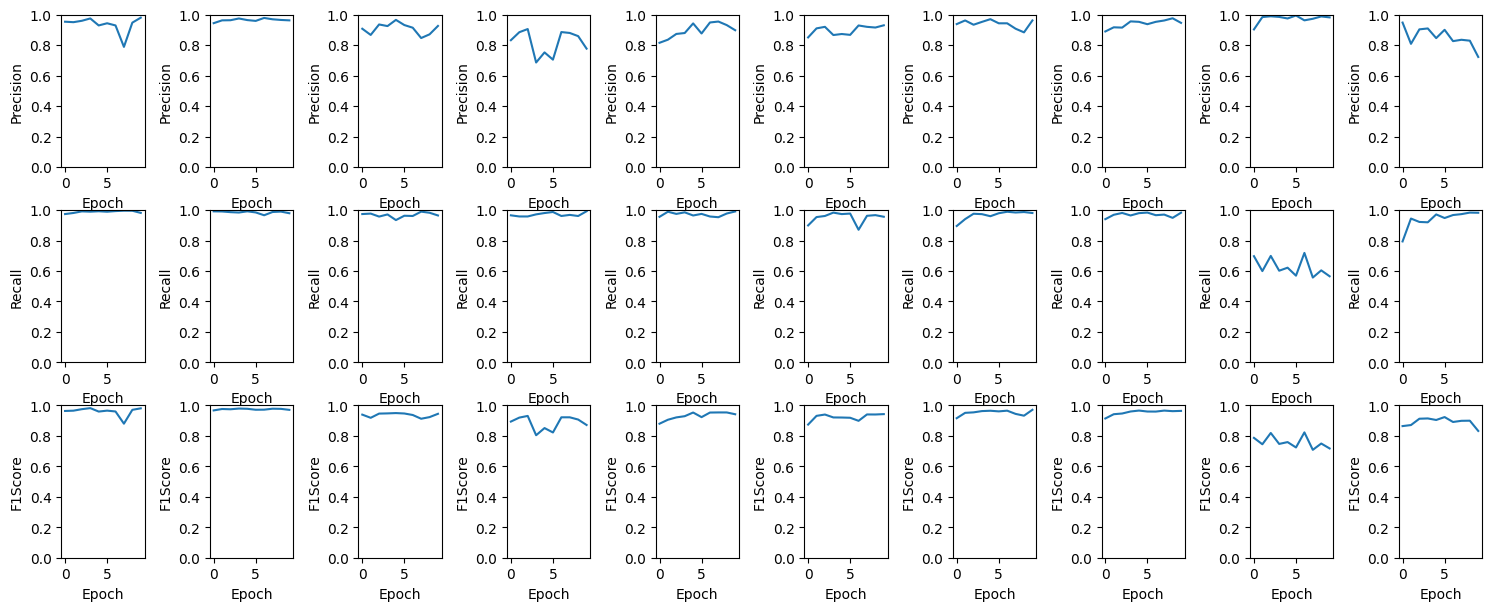


Testing: Adagrad
313/313 [==============================] - 0s 1ms/step

Never reached 90% accuracy
313/313 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      1015
           1       0.96      0.96      0.96      1141
           2       0.89      0.89      0.89      1026
           3       0.87      0.87      0.87      1019
           4       0.89      0.88      0.88       996
           5       0.85      0.86      0.85       880
           6       0.91      0.92      0.91       951
           7       0.89      0.91      0.90      1013
           8       0.84      0.86      0.85       952
           9       0.86      0.86      0.86      1007

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



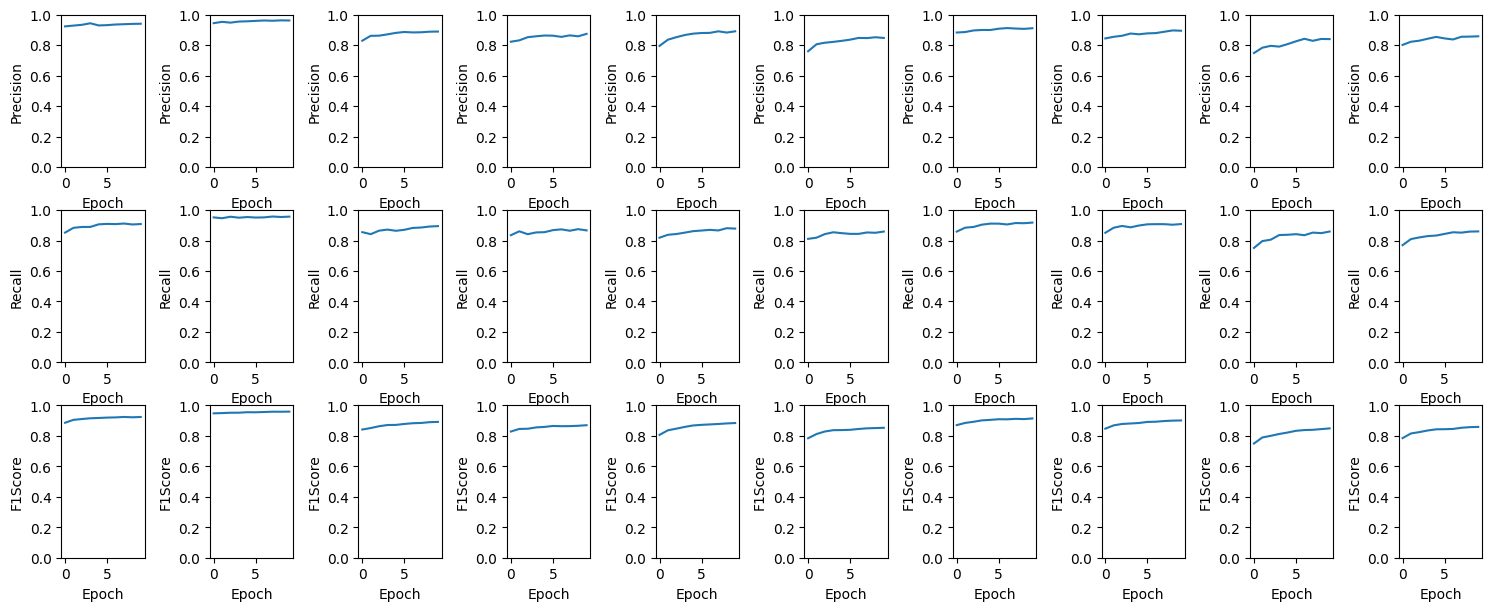

In [290]:
optimizers = ['SGD', 'Adam', 'RMSprop', 'Adagrad']
nn_models = {}
training_results = {}

for optimizer in optimizers:
    model = build_model()
    nn_models[optimizer] = model

    training_results[optimizer] = test_model(model, optimizer)

In our investigation we`ve compared 4 optimizers - SGD, Adam, RMSprop and Adagrad.
Ranking from the worst to the best optimizer based on accuracy, we have 
1) Stochastic Gradient Descend, one of the simplest optimizers that relies on gradient approximation, which may be good for really large data sets, as it uses only subset of validation data for weight-tuning and is pretty fast. In our task it reaches second best score with mostly consistent monotonic growth across the labels. However, it does not work good enough out of the box and requires fine-tuning (lowering learning rate) otherwise it finds only local minimum
2) Adagrad - adaptive gradient descent which sets different learning rates to parameters, which could have been useful in our case (input has ~800 parameters and hidden layers 128 an 64, respectively and many of those would be far from valuable features) , but had proven otherwise - it has better consistency than SGD (and any other optimization method shown), but goes very slow
3) RMSprop - better version of Adagrad, where the concept of forgetting is introduced to per-parameter learning rates, as a result it also has better results, but is very inconsistent  
4) Adam - method where both learning rate and momentum estimation are used, both with forgetting - it has the best results and considered industry standard, it also shows some minor inconsistency